Imports:

In [1]:
import tensorflow.keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import pydot
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv3D, Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

Num GPUs: 1


Load images:

In [23]:
folder_path = 'food/'
aim_folder_path = 'foodpreprocessed/'

img_width, img_height = 224, 224

# load all images into a list
file_list = sorted(os.listdir(folder_path))
images = []
names = []
i = 0
for img in file_list:
    if img == '.DS_Store':  # ignore stupid fookin mac file that wont go away
        continue
    thisname = img.split('.')[0]
    names.append(img)
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    np.save(aim_folder_path+thisname, img)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)

Load triplets:

In [24]:
df_triplets = pd.read_csv('train_triplets.txt', sep=" ", header=None)
print(df_triplets)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
59510   466  2952  2530
59511  2646  3580  2359
59512  3255  4844  4334
59513  2136  4619   161
59514  2509  2552  3406

[59515 rows x 3 columns]


Train-validation split:

In [25]:
df_triplets_train = pd.DataFrame(columns = [0, 1, 2])
df_triplets_val = pd.DataFrame(columns = [0, 1, 2])

N = 330
for idx, row in df_triplets.iterrows():
  if idx < N:  # first N rows go in train
    df_triplets_train = df_triplets_train.append(row)
  elif all(x not in df_triplets_train.values for x in [row[0], row[1], row[2]]):  # else if images not in train add to val
    df_triplets_val = df_triplets_val.append(row)
  elif all(x not in df_triplets_val.values for x in [row[0], row[1], row[2]]):  # else if images not in val add to train
    df_triplets_train = df_triplets_train.append(row)
  # else we discard triplet
  
df_triplets_train = df_triplets_train.reset_index(drop=True)
df_triplets_val = df_triplets_val.reset_index(drop=True)

print(df_triplets_train)
print(df_triplets_val)

          0     1     2
0      2461  3450  2678
1      2299  2499  4987
2      4663  1056  3029
3      4532  1186  1297
4      3454  3809  2204
...     ...   ...   ...
16025   450   219  4712
16026   236  1229  4090
16027   880  1818   621
16028   466  2952  2530
16029  2646  3580  2359

[16030 rows x 3 columns]
         0     1     2
0      683  2848  2039
1     4404  2384  2478
2     1019  4241  4114
3     4108  1020  1523
4       64  2252   773
...    ...   ...   ...
4963  4020  2390  1285
4964  4990  4028  2647
4965  1716  4431  3398
4966  1550  1222  1140
4967  1940    38  2869

[4968 rows x 3 columns]


Swap every other element so that 0/1 labels are balanced:

Create labels:

In [26]:
y_train = np.empty((df_triplets_train.shape[0], 1))
y_train[:] = 1
print(y_train)

y_val = np.empty((df_triplets_val.shape[0], 1))
y_val[:] = 1
print(y_val)

df_triplets_train = df_triplets_train.sample(frac=1).reset_index(drop=True)
df_triplets_val = df_triplets_val.sample(frac=1).reset_index(drop=True)

df_triplets_train.to_pickle("df_tiplets_train_random")
df_triplets_val.to_pickle("df_tiplets_val_random")
np.save("y_train_random",y_train)
np.save("y_val_random",y_val)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


Transform triplets of image indexes --> triplets of images:

In [2]:
def imageLoader(files, y_values, batch_size):

    im0 = files[0]
    im1 = files[1]
    im2 = files[2]
    
    L = len(im0)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X1 = someMethodToLoadImages(im0[batch_start:limit])
            X2 = someMethodToLoadImages(im1[batch_start:limit])
            X3 = someMethodToLoadImages(im2[batch_start:limit])
            X = [X1,X2,X3]
            Y = y_values[batch_start:batch_end]
            #print(Y)
            Y = np.vstack(Y)
            #print(X1.shape)
            #print(Y.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
            
def someMethodToLoadImages(im0):
    train_0 = []
    aim_folder_path = 'foodpreprocessed/'

    for imID in im0:
        train_0.append(np.load(aim_folder_path+str(imID).zfill(5)+'.npy'))
      #  print(train_0[-1].shape)
    train_0 = np.vstack(train_0)
    
    return train_0

def triplet_loss(y_true, y_pred, alpha = 0.1):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    #print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

Setup model for three CNNs:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputA (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inputB (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inputC (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5)            12924421    inputA[0][0]                     
                                                                 inputB[0][0]                 

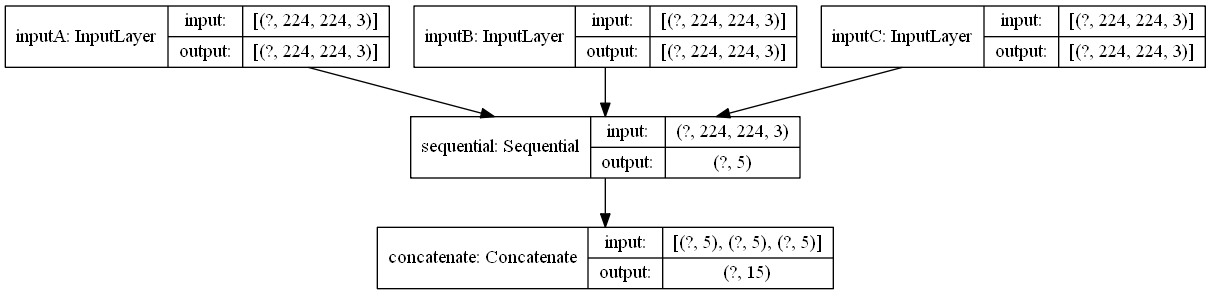

In [3]:
def createBaseNetwork(inDims, outDims):   
    model = Sequential()
    #model.add(BatchNormalization()) ###
    model.add(Conv2D(filters=384, # 256
                     kernel_size=(11,11), strides=(5,5), padding="same",
                     input_shape=(inDims[0], inDims[1], inDims[2]), activation="relu",
                     name="conv0"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="pool0"))
    model.add(BatchNormalization()) ###
    model.add(Conv2D(filters=512, #512
                     kernel_size=(7,7), strides=(3,4), padding="same",
                     activation="relu", name="conv1"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="pool1"))
    model.add(Flatten(name="flatten"))
    model.add(Dropout(0.3)) # 0.3
    model.add(Dense(512, activation="relu", name="dense0", kernel_regularizer=l2(0.005))) # 256 # 0.001
    model.add(Dropout(0.3)) # 0.3
    model.add(Dense(outDims, activation="linear", name="embedding"))
    return model

inputA = keras.Input(shape=(224,224,3),name='inputA')
inputB = keras.Input(shape=(224,224,3),name='inputB')
inputC = keras.Input(shape=(224,224,3),name='inputC')
outputDims = 5

sharedNetwork = createBaseNetwork(inDims=[224, 224, 3], outDims=outputDims)

a = sharedNetwork(inputA)
b = sharedNetwork(inputB)
c = sharedNetwork(inputC)

out = layers.concatenate([a,b,c])

#out = layers.Dense(50, activation='relu')(out)
#out = Dropout(rate = .2)(out)
#out = layers.Dense(50,activation='relu')(out)
#out = Dropout(rate = .2)(out)
#out = layers.Dense(1,activation='sigmoid',name='output')(out)

model = Model(inputs=[inputA,inputB,inputC], outputs=out)

opt = opt = Adam(learning_rate=0.0001)
model.compile(loss=triplet_loss, optimizer=opt, metrics=['accuracy'])

model.summary()
dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

Train model:

In [4]:
df_triplets_train = pd.read_pickle("df_tiplets_train_random")
df_triplets_val = pd.read_pickle("df_tiplets_val_random")
y_train = np.load('y_train_random.npy')
y_val = np.load('y_val_random.npy')

batch_size = 12
spe = df_triplets_train.shape[0]//batch_size
vs = df_triplets_val.shape[0]//batch_size
my_training_batch_generator = imageLoader(df_triplets_train, y_train, batch_size)
my_validation_batch_generator = imageLoader(df_triplets_val, y_val, batch_size)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(my_training_batch_generator,validation_data=(my_validation_batch_generator), steps_per_epoch=spe, validation_steps=vs, shuffle=True, epochs=30,callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1335 steps, validate for 414 steps
Epoch 1/30
1335/1335 [==============================] - 371s 278ms/step - loss: 5.7314 - accuracy: 0.0863 - val_loss: 4.8153 - val_accuracy: 0.0395
Epoch 2/30
1335/1335 [==============================] - 360s 270ms/step - loss: 4.8617 - accuracy: 0.0616 - val_loss: 4.8005 - val_accuracy: 0.0364
Epoch 3/30
1335/1335 [==============================] - 357s 267ms/step - loss: 4.8114 - accuracy: 0.0582 - val_loss: 4.7884 - val_accuracy: 0.0376
Epoch 4/30
1335/1335 [==============================] - 358s 268ms/step - loss: 4.7884 - accuracy: 0.0700 - val_loss: 4.7755 - val_accuracy: 0.0415
Epoch 5/30
1335/1335 [==============================] - 357s 268ms/step - loss: 4.7728 - accuracy: 0.0675 - val_loss: 4.7624 - val_accuracy: 0.0336
Epoch 6/30
1335/1335 [==============================] - 356s 267ms/step - loss: 4.7591 - accuracy: 0.0664 - val_loss: 4.7499 - val_accuracy: 0.0250
Epoch 7/30
1335/1

In [10]:
model.save('taste-similarity2.h5')

In [11]:
def imageLoaderTest(an,pos,neg, batch_size):

    im0 = an
    im1 = pos
    im2 = neg
    L = len(im0)
    #this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X1 = someMethodToLoadImages(im0[batch_start:limit])
            X2 = someMethodToLoadImages(im1[batch_start:limit])
            X3 = someMethodToLoadImages(im2[batch_start:limit])
            X = [X1,X2,X3]
            #print(X1.shape)
            yield (X) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

df_triplets_test = pd.read_csv('test_triplets.txt', sep=" ", header=None)
number_of_rows = len(df_triplets_test)
predictions = []
col0 = df_triplets_test[0]
col1 = df_triplets_test[1]
col2 = df_triplets_test[2]

batch_size=16
testgenerator = imageLoaderTest(col0,col1,col2,batch_size)
spe = df_triplets_test.shape[0]//batch_size + 1
y_pred = model.predict(testgenerator,verbose=1,steps=spe)
predictions.append(y_pred)

3722/3722 [==============================] - 364s 98ms/step


In [12]:
print(y_pred.shape)
print(spe)

(59544, 15)
3722


In [14]:
answer = []
for i in range(0,len(y_pred)):
    row = y_pred[i]
    row_length = len(row)
    anchor = row[0:int(row_length*1/3)]
    positive = row[int(row_length*1/3):int(row_length*2/3)]
    negative = row[int(row_length*2/3):int(row_length*3/3)]
    # distance between the anchor and the positive
    pos_dist = np.sum(np.square(anchor-positive))
    # distance between the anchor and the negative
    neg_dist = np.sum(np.square(anchor-negative))
    if pos_dist<neg_dist:
        answer.append(1)
    else:
        answer.append(0)
print(len(answer))
pd.DataFrame(answer).to_csv("Answer.csv", header=None, index=None)

59544


In [15]:
df_triplets_test = pd.read_csv('test_triplets.txt', sep=" ", header=None)
len(df_triplets_test)

59544